# Imports

In [1]:
import pandas as pd
import numpy as np
np.random.seed(2121)

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import BayesianRidge
from sklearn.decomposition import PCA

In [2]:
rdf_ydf = pd.read_csv('../data/rdf_ydf_feature_extracted.csv')

In [3]:
rdf = rdf_ydf[['runs_bat_pg_1yr',
       'runs_bat_pg_2yr', 'runs_bat_pg_3yr', 'runs_br_pg_1yr',
       'runs_br_pg_2yr', 'runs_br_pg_3yr', 'runs_dp_pg_1yr', 'runs_dp_pg_2yr',
       'runs_dp_pg_3yr', 'runs_defense_pg_1yr', 'runs_defense_pg_2yr',
       'runs_defense_pg_3yr', 'runs_position_pg_1yr', 'runs_position_pg_2yr',
       'runs_position_pg_3yr','runs_total_pg']]

ydf = rdf_ydf[['opprpg', 'opprpg_1yr', 'opprpg_2yr', 'opprpg_3yr']]

others=rdf_ydf[[c for c in rdf_ydf.columns if c not in rdf.columns
                                  if c not in ydf.columns]]

# Train-Test Split

In [4]:
target = 'runs_total_pg'
y_rdf = rdf[target]
X_rdf = rdf[[col for col in rdf.columns if col != target]]

X_rdf_train, X_rdf_test, y_rdf_train, y_rdf_test =\
    train_test_split(X_rdf, y_rdf,
                     test_size=0.2,
                     shuffle=True,
                     random_state = 1212)

target = 'opprpg'

y_ydf = ydf[target]
X_ydf = ydf[[col for col in ydf.columns if col != target]]

X_ydf_train, X_ydf_test, y_ydf_train, y_ydf_test =\
    train_test_split(X_ydf, y_ydf,
                     test_size=0.2,
                     shuffle=True,
                     random_state = 1212)

target = 'waa_pg'

y_odf = others[target]
X_odf = others[[col for col in others.columns if col != target]]

X_odf_train, X_odf_test, y_odf_train, y_odf_test =\
    train_test_split(X_odf, y_odf,
                     test_size=0.2,
                     shuffle=True,
                     random_state = 1212)

After splitting, store X_test before standard scaling, etc. for baseline calculations in the modeling workbook.

In [5]:
X_odf_test.to_csv('../data/X_test_rdf_ydf_for_baseline.csv')

# RDF Preprocessing

## Standard Scale

In [6]:
# initialize
ss = StandardScaler()

# fit on Train
X_rdf_train_ss = pd.DataFrame(ss.fit_transform(X_rdf_train),
                              columns = X_rdf_train.columns,
                              index = X_rdf_train.index)

# transform test
X_rdf_test_ss = pd.DataFrame(ss.transform(X_rdf_test),
                             columns = X_rdf_test.columns,
                             index = X_rdf_test.index)

# YDF Preprocessing

## Standard Scale

In [7]:
# initialize
ss = StandardScaler()

# fit on Train
X_ydf_train_ss = pd.DataFrame(ss.fit_transform(X_ydf_train),
                              columns = X_ydf_train.columns,
                              index = X_ydf_train.index)

# transform test
X_ydf_test_ss = pd.DataFrame(ss.transform(X_ydf_test),
                             columns = X_ydf_test.columns,
                             index = X_ydf_test.index)

# Others Preprocessing

## Standard Scale

In [8]:
# initialize
ss = StandardScaler()

# fit on Train
X_odf_train_ss = pd.DataFrame(ss.fit_transform(X_odf_train),
                              columns = X_odf_train.columns,
                              index = X_odf_train.index)

# transform test
X_odf_test_ss = pd.DataFrame(ss.transform(X_odf_test),
                             columns = X_odf_test.columns,
                             index = X_odf_test.index)

## RFE

Similar to the reason in workbook 3, want to reduce to at least the best 20 features.

In [9]:
rfecv = RFECV(
            estimator=BayesianRidge(),
            step = 1,
            cv = 5,
            scoring='r2',
            min_features_to_select = 20)

rfecv.fit(X_odf_train_ss,y_odf_train)

odf_cols_to_keep = X_odf_train_ss.T[rfecv.ranking_==1].T.columns
odf_cols_to_pc = X_odf_train_ss.T[rfecv.ranking_!=1].T.columns

print(f'# of Columns Kept: {len(odf_cols_to_keep)}')
print(f'# of Columns Dropped: {len(odf_cols_to_pc)}')

# of Columns Kept: 20
# of Columns Dropped: 33


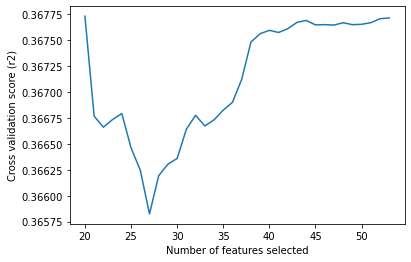

In [10]:
# https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (r2)")
plt.plot(
    range(20, len(rfecv.cv_results_['mean_test_score'])+20),
    rfecv.cv_results_['mean_test_score']
)
plt.show()

Cross validation scores creep back up around 40 features being selected but they never surpass the 20-feature model.

### Removed Features

In [11]:
for i in range(0,35,5):
    print(', '.join(odf_cols_to_pc.sort_values()[i:i+5]))

g_1b_share_1yr, g_1b_share_3yr, g_1yr, g_2b_share_1yr, g_2b_share_2yr
g_2yr, g_3b_share_1yr, g_3b_share_2yr, g_3yr, g_cf_share_2yr
g_cf_share_3yr, g_cof_share_2yr, g_cof_share_3yr, g_dh_share_2yr, g_of_2yr
g_ss_share_1yr, g_ss_share_2yr, inn_per_team_gp_1yr, inn_per_team_gp_2yr, inn_pg_1yr
inn_pg_2yr, inn_pg_3yr, pa_per_team_gp_1yr, pa_per_team_gp_2yr, pa_pg_2yr
pa_pg_3yr, percent_team_gp_1yr, percent_team_gp_2yr, percent_team_gp_3yr, team_gp_1yr
team_gp_2yr, team_gp_3yr, year_id


## PCA

For the same reasons as workbook 3, add some of the signal back

In [12]:
pca = PCA().fit(X_odf_train_ss[odf_cols_to_pc])

cum_var_exp = np.cumsum(pca.explained_variance_ratio_) * 100

for i, l in enumerate(pca.explained_variance_[:5]):
    print('PC {}: {:.2f} --> {:.2f}% --> {:.2f}%'.format(i, l,
                                             l * 100 / sum(pca.explained_variance_),
                                             cum_var_exp[i]))

PC 0: 5.36 --> 16.24% --> 16.24%
PC 1: 3.51 --> 10.62% --> 26.85%
PC 2: 2.63 --> 7.95% --> 34.81%
PC 3: 2.42 --> 7.34% --> 42.15%
PC 4: 2.25 --> 6.82% --> 48.97%


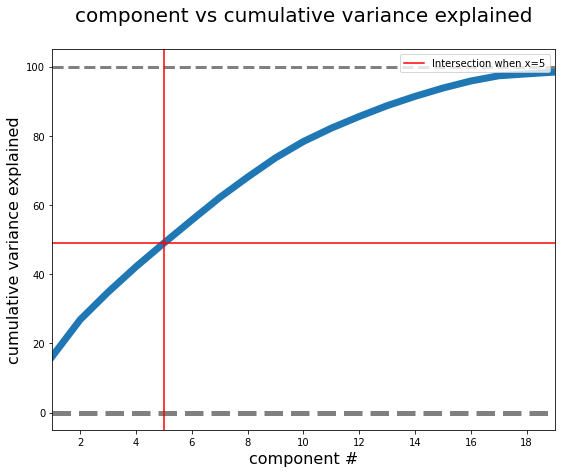

In [13]:
cum_var_exp = np.cumsum(pca.explained_variance_ratio_) * 100
plt.figure(figsize=(9,7))
component_number = range(1, len(odf_cols_to_pc)+1)
plt.plot(component_number, cum_var_exp, lw=7)
plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
plt.axhline(y=100, linewidth=3, color='grey', ls='dashed')
ax = plt.gca()
ax.set_xlim([1,19])
ax.set_ylim([-5,105])
ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component #', fontsize=16)  
ax.set_title('component vs cumulative variance explained\n', fontsize=20)
ax.axhline(y=np.cumsum(pca.explained_variance_ratio_)[4]*100, c='r', label='Intersection when x=5')
ax.axvline(x=5,  c='r')
ax.legend();

In [14]:
odf_pca_train = pd.DataFrame(pca.transform(X_odf_train_ss[odf_cols_to_pc])[:,:5],
                     columns = ['pc_' + str(i) for i in range(5)],
                     index = X_odf_train_ss.index)

odf_pca_test = pd.DataFrame(pca.transform(X_odf_test_ss[odf_cols_to_pc])[:,:5],
                     columns = ['pc_' + str(i) for i in range(5)],
                     index = X_odf_test_ss.index)

In [15]:
X_odf_train_ss = pd.concat([X_odf_train_ss[odf_cols_to_keep], odf_pca_train], axis=1)
X_odf_test_ss = pd.concat([X_odf_test_ss[odf_cols_to_keep], odf_pca_test], axis=1)

# Exports

In [16]:
# consolidate test and train files
rdf_test = pd.merge(X_rdf_test_ss,y_rdf_test, left_index=True, right_index=True)
rdf_train = pd.merge(X_rdf_train_ss,y_rdf_train, left_index=True, right_index=True)

ydf_test = pd.merge(X_ydf_test_ss,y_ydf_test, left_index=True, right_index=True)
ydf_train = pd.merge(X_ydf_train_ss,y_ydf_train, left_index=True, right_index=True)

odf_test = pd.merge(X_odf_test_ss,y_odf_test, left_index=True, right_index=True)
odf_train = pd.merge(X_odf_train_ss,y_odf_train, left_index=True, right_index=True)


# add flag to train
rdf_train['is_train'] = 1

# concat train and test, fill is_train with 0 in test
rdf_preprocessed = pd.concat([rdf_test,rdf_train]).fillna(0)

In [17]:
rdf_ydf_preprocessed=\
pd.merge(
        pd.merge(rdf_preprocessed, pd.concat([ydf_test,ydf_train]),
                 how = 'inner',
                 left_index=True, right_index=True),
        pd.concat([odf_test,odf_train]),
        how = 'inner',
        left_index=True, right_index=True)

In [18]:
rdf_ydf_preprocessed.to_csv('../data/rdf_ydf_preprocessed.csv')